<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/NTK_circle_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install torchviz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.model_selection import train_test_split 
import seaborn as sns
#from torchviz import make_dot
from google.colab import files
from scipy.linalg import eigh

%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

**Input Generation**

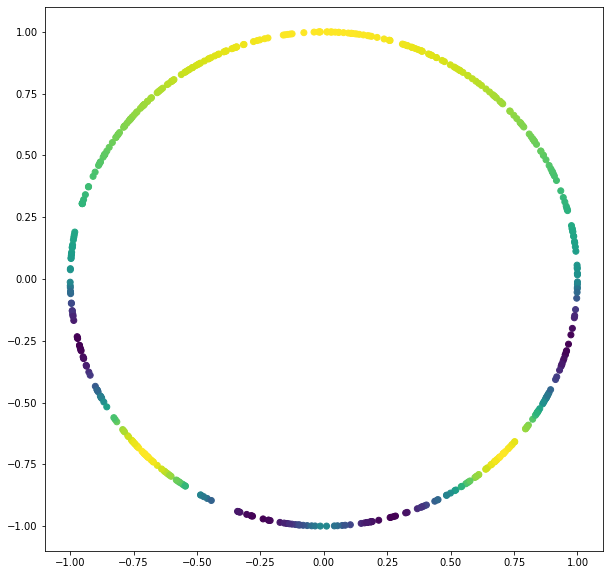

In [ ]:
class CustomDataset(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = torch.tensor(X)
          self.y = torch.tensor(Y)

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx].float()


n_data_points = 500
x1 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))
x2 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))

X = np.concatenate((x1, x2), axis = 1)
X = X/np.sqrt(x1**2 + x2**2)

Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(6*np.arcsin(i))]  for i in X[:,1] ]
Y = np.array(Y)

n_data = len(Y)

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c = Y)
#plt.savefig("Input Data")



#sorted_arg = np.argsort(X[:, 0])
sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
X_sorted = X[sorted_arg]
Y_sorted = Y[sorted_arg]

batch_size = len(Y)
dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)


batch_size = 32
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)

In [ ]:
from torch.autograd import grad

**MLP**

In [ ]:
batched_grads = 0
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    grads = []
    param_len = torch.cat([p.flatten() for p in list(mlp_model.parameters())]).size()[0]
    for batch,batch_data  in enumerate(dataloader):
    
      all_per_sample_gradients = [np.zeros(shape = (param_len,1))]
      optimizer.zero_grad()
      for x,y in zip(batch_data[0], batch_data[1]):
   
        X, y = x.to(device), y.to(device)
        pred, _ = model(X.float())
        
        loss = loss_fn(pred, y)
        
        loss.backward()

        per_sample_gradients = np.concatenate([p.grad.flatten().detach().clone().to('cpu') for p in model.parameters()])
        per_sample_gradients = np.reshape(per_sample_gradients,(per_sample_gradients.shape[0],1))
        all_per_sample_gradients.append(per_sample_gradients-np.sum(all_per_sample_gradients, axis = 0))
        
        #grads = grad(outputs = loss, inputs = model.parameters())
        #print(grads[0].size())
        # for idx, params in enumerate(mlp_model.parameters()):
        #   print(idx, params.grad.size())
      optimizer.step()
      grads.append(all_per_sample_gradients[1:])
      if batch%5 == 0:
          loss, current = loss.item(), batch * len(X)
          print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return grads

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred, out, test_loss

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, n_hidden_layers, n_neurons, architecture_type):
        super(NeuralNet, self).__init__()
        
        # self.n_neurons = n_neurons
        # self.fc1 = nn.Linear(2, self.n_neurons)
        # self.fc2 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc3 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc4 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc5 = nn.Linear(self.n_neurons, self.n_neurons)
        # self.fc6 = nn.Linear(self.n_neurons, 1)


        self.architecture_type = architecture_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        
        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = True).to(device)])
        #self.dlgn_Sf_layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
        
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = True).to(device))
        
        
        
        self.layers.append(nn.Linear( self.n_neurons, 1, bias = True).to(device))



  def forward(self, x, batch = None):
        # x = self.fc1(x)
        # o1 = torch.relu(x)
        # x = self.fc2(o1)
        # o2 = torch.relu(x)
        # x = self.fc3(o2)
        # o3 = torch.relu(x)
        # x = self.fc4(o3)
        # o4 = torch.relu(x)
        # x = self.fc5(o4)
        # o5 = torch.relu(x)
        # x = self.fc6(o5)

        hidden_layer_outputs = []
      
        
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          out = torch.relu(x)
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[-1](x)
    
        return x, hidden_layer_outputs
        

In [ ]:
# model_architecture_type = "MLP"
# n_neurons = 32
# n_hidden_layers = 4
# model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}


# mlp_model = NeuralNet(n_neurons).to(device)
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 3e-3)  

# weights_all_epochs = []
# losses = []
# model_learning_status = "UnLearned"

In [ ]:
# epochs = 300
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     #get_layer_weights()

#     pred = train(train_dataloader,mlp_model, loss_fn, optimizer)
#     _,_, loss = test(test_dataloader,mlp_model, loss_fn)
#     losses.append(loss)
# print("Done!")
# model_learning_status = "Learned"

**Visualizing Kernels for MLP**

In [ ]:
def get_kernels(hidden_layer_outputs):
  n_hidden_layer = len(hidden_layer_outputs)
  for i in range(n_hidden_layer):
    hidden_layer_outputs[i] = np.sign(hidden_layer_outputs[i].detach().to("cpu"))

  hidden_layer_kernels = []
  for i in range(n_hidden_layer):
    hidden_layer_kernels.append(np.matmul(hidden_layer_outputs[i].numpy(),hidden_layer_outputs[i].numpy().T))

  lambda_matrix = hidden_layer_kernels[0]
  for i in range(1,n_hidden_layer):
    lambda_matrix = np.multiply(lambda_matrix, hidden_layer_kernels[i])
  
  kernels = hidden_layer_kernels + [lambda_matrix]
  
  return kernels

In [ ]:
def plot_heatmap(K, model_info):
  for i in range(len(K)):
    plt.figure(figsize = (15,15))
    ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth=.2)
    model_title = model_info["model_architecture_type"] +'(' + 'n_h_l = '+ str(model_info["n_hidden_layers"])+ ', n_n = '+ str(model_info["n_neurons"])+', ' +model_learning_status+', K'+str(i+1) +', ' +'Run=' + str(model_info["Run"])+", Y'KY_n = "+  model_info["Y'KY"][i] +')'
    if i < len(K)-1:
      plt.title(model_title)
      plt.savefig(model_title + ".png", format = "png")
      #files.download(model_title+".png") 
    else:
      model_title = model_info["model_architecture_type"] +'('+ 'n_h_l = '+ str(model_info["n_hidden_layers"])+ ', n_n = '+ str(model_info["n_neurons"]) +', ' + model_learning_status+', ' + 'NTK' + ', '+ "Y'KY_n = "+ model_info["Y'KY"][i] +', ' + 'Run=' + str(model_info["Run"])+')'
      plt.title(model_title)
      plt.savefig(model_title+ ".png", format = "png")
      #files.download(model_title+".png") 
    plt.show()

In [ ]:
# prediction, hidden_layer_outputs,_ = test(dataloader,mlp_model, loss_fn)

# kernels = get_kernels(hidden_layer_outputs)
# kernels_over_5.append(kernels)

In [ ]:
# kernels_mean = np.mean(np.array(kernels_over_5), axis = 0)
# kernels_over_5 = []

loss: 0.891005 Batch:0 [    0/  500]
loss: 0.047180 Batch:5 [   10/  500]
loss: 0.690038 Batch:10 [   20/  500]
loss: 0.018357 Batch:15 [   30/  500]


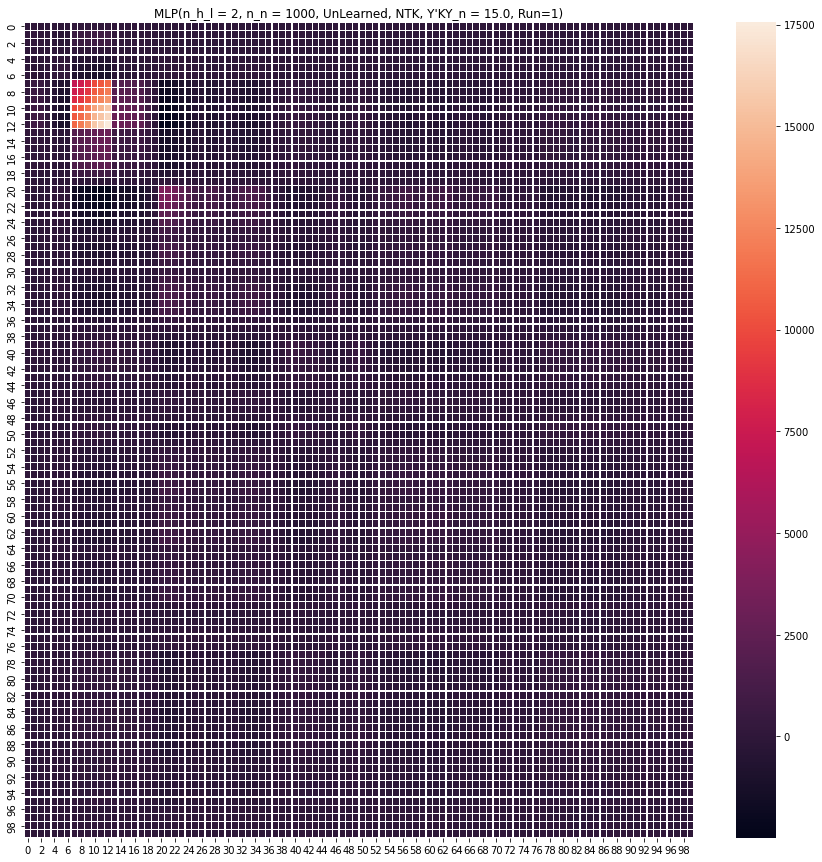

Epoch 1
-------------------------------
loss: 6.224157 Batch:0 [    0/  450]
loss: 2.304823 Batch:5 [   10/  450]
loss: 0.400851 Batch:10 [   20/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.446019 

Epoch 2
-------------------------------
loss: 0.068008 Batch:0 [    0/  450]
loss: 0.483803 Batch:5 [   10/  450]
loss: 0.672402 Batch:10 [   20/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.357721 

Epoch 3
-------------------------------
loss: 0.663032 Batch:0 [    0/  450]
loss: 0.013805 Batch:5 [   10/  450]
loss: 0.000251 Batch:10 [   20/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.304032 

Epoch 4
-------------------------------
loss: 0.019485 Batch:0 [    0/  450]
loss: 0.700846 Batch:5 [   10/  450]
loss: 0.002001 Batch:10 [   20/  450]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.303269 

Epoch 5
-------------------------------
loss: 0.000551 Batch:0 [    0/  450]
loss: 0.001440 Batch:5 [   10/  450]
loss: 0.000183 Batch:10 [   20/  450]
Test Error: 
 Accuracy: 0.0%, Avg lo

KeyboardInterrupt: ignored

In [ ]:
# for n_h_l in [3]:
#   n_hidden_layers = n_h_l
#   for n_n in [512]:
#     n_neurons = n_n

#     model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
#     kernels_over_5 = []
#     for i in range(5):
#       model_info["Run"] = str(i+1)





info_list = []
model_architecture_type = "MLP"

for n_h_l in [2]:
  n_hidden_layers = n_h_l
  for n_n in [1000]:
    n_neurons = n_n

    model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    kernels_over_5 = []
    rand_kernels_over_5 = []
    for i in range(5):
      model_info["Run"] = str(i+1)
      n_data_points = 500
      x1 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))
      x2 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))

      X = np.concatenate((x1, x2), axis = 1)
      X = X/np.sqrt(x1**2 + x2**2)

      Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
      Y = np.array(Y)

      n_data = len(Y)

      #plt.figure(figsize=(10,10))
      #plt.scatter(X[:,0], X[:,1], c = Y)
      #plt.savefig("Input Data")



      #sorted_arg = np.argsort(X[:, 0])
      sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
      X_sorted = X[sorted_arg]
      Y_sorted = Y[sorted_arg]

      batch_size = 32#len(Y)
      dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)
      
      batch_size = 32
      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

      train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
      test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)



      mlp_model = NeuralNet( n_hidden_layers, n_neurons, model_architecture_type).to(device)
      loss_fn = nn.MSELoss()
      optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 3e-3)  
      #weights_all_epochs = []
      #losses = []
      model_learning_status = "UnLearned"
      
      
      grads = train(dataloader,mlp_model, loss_fn, optimizer)
      grads = np.concatenate(grads)
      grads = np.reshape(grads, (grads.shape[0],grads.shape[1]))
      NTK = np.matmul(grads, grads.T)

      kernels = [NTK]
      rand_kernels_over_5.append(kernels)
      YKYs = []
      for i in range(len(kernels)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
        eigen_vals = eigh(kernels[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      model_info["Y'KY"] = YKYs
      plot_heatmap(kernels, model_info)
      

      epochs = 1000
      for t in range(epochs):
          print(f"Epoch {t+1}\n-------------------------------")
          #get_layer_weights()

          _ = train(train_dataloader,mlp_model, loss_fn, optimizer)
          _,_, loss = test(test_dataloader,mlp_model, loss_fn)
          #losses.append(loss)
      grads = train(dataloader,mlp_model, loss_fn, optimizer)
      print("Done!")

      
      model_learning_status = "Learned"
      grads = train(dataloader,mlp_model, loss_fn, optimizer)
      grads = np.concatenate(grads)
      grads = np.reshape(grads, (grads.shape[0],grads.shape[1]))
      NTK = np.matmul(grads, grads.T)
      kernels = [NTK]
      kernels_over_5.append(kernels)
      YKYs = []
      for i in range(len(kernels)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
        eigen_vals = eigh(kernels[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      model_info["Y'KY"] = YKYs
      plot_heatmap(kernels, model_info)


    

    kernels_mean = np.mean(np.array(rand_kernels_over_5), axis = 0)
    YKYs = []
    for i in range(len(kernels_mean)):
      YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
      eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
      YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
    model_learning_status = "UnLearned"
    model_info["Y'KY"] = YKYs
    model_info["Run"] = "mean"
    model_info["model_learning_status"] = "UnLearned"
    info_list.append(list(model_info.values()).copy())
    plot_heatmap(kernels_mean, model_info)
    

    kernels_mean = np.mean(np.array(kernels_over_5), axis = 0)
    YKYs = []
    for i in range(len(kernels_mean)):
      YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
      eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
      YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
    model_learning_status = "Learned"
    model_info["Y'KY"] = YKYs
    model_info["Run"] = "mean"
    model_info["model_learning_status"] = "Learned"
    info_list.append(list(model_info.values()).copy())
    plot_heatmap(kernels_mean, model_info)
    

In [ ]:
!zip -r NTK10_all.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.12.03/ (stored 0%)
  adding: content/.config/logs/2021.12.03/14.32.50.522723.log (deflated 53%)
  adding: content/.config/logs/2021.12.03/14.33.16.964195.log (deflated 54%)
  adding: content/.config/logs/2021.12.03/14.33.37.701606.log (deflated 53%)
  adding: content/.config/logs/2021.12.03/14.33.36.903459.log (deflated 54%)
  adding: content/.config/logs/2021.12.03/14.33.09.955489.log (deflated 86%)
  adding: content/.config/logs/2021.12.03/14.32.30.027140.log (deflated 91%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.con

In [ ]:
# !rm -r *

In [ ]:
# plot_heatmap(kernels_mean, model_info)

**Testing Layer by Layer Hypothesis**

In [ ]:

def get_layer_weights():
  l1_weight = mlp_model.fc1.weight.detach().to("cpu").numpy()
  l2_weight = mlp_model.fc2.weight.detach().to("cpu").numpy()
  l3_weight = mlp_model.fc3.weight.detach().to("cpu").numpy()
  weights_all_epochs.append([l1_weight, l2_weight, l3_weight])



In [ ]:

change = []
for i in range(len(weights_all_epochs)):
  layer1_diff = weights_all_epochs[i][0]-weights_all_epochs[0][0]
  other_layer_diff = np.array(weights_all_epochs[i][1:])-np.array(weights_all_epochs[0][1:])
  change.append([np.mean(np.square(layer1_diff)),np.mean(np.square(other_layer_diff[0])), np.mean(np.square(other_layer_diff[1]))])

NameError: ignored

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(change)), np.array(change)[:,0], label = "Layer 1")
plt.plot(np.arange(len(change)), np.array(change)[:,1], label = "Layer 2")
plt.plot(np.arange(len(change)), np.array(change)[:,2], label = "Lay4er 3")
plt.plot(np.arange(len(change)),losses, label = "Test loss")

plt.legend()
plt.show()

In [ ]:
interval = 2
change = []
for i in range(5,len(weights_all_epochs)):
  layer1_diff = weights_all_epochs[i][0]-weights_all_epochs[i-interval][0]
  other_layer_diff = np.array(weights_all_epochs[i][1:])-np.array(weights_all_epochs[i-interval][1:])
  change.append([np.mean(np.square(layer1_diff)),np.mean(np.square(other_layer_diff[0])), np.mean(np.square(other_layer_diff[1]))])

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(np.arange(len(change)), np.array(change)[:,0], label = "Layer 1")
plt.plot(np.arange(len(change)), np.array(change)[:,1], label = "Layer 2")
plt.plot(np.arange(len(change)), np.array(change)[:,2], label = "Layer 3")
#plt.plot(np.arange(len(change)+1),losses, label = "Test loss")

plt.legend()
plt.show()

In [ ]:
interval = 3
change = []
layer1_diffs = []
other_layer_diffs = []
for i in range(5,len(weights_all_epochs)):
  layer1_diff = np.square(weights_all_epochs[i][0]-weights_all_epochs[i-interval][0])
  other_layer_diff =  np.square(np.array(weights_all_epochs[i][1:])-np.array(weights_all_epochs[i-interval][1:]))
  layer1_diffs.append(layer1_diff.flatten())
  other_layer_diffs.append([other_layer_diff[0].flatten(), other_layer_diff[1].flatten()])

In [ ]:
plt.figure(figsize=(20,20))
#plt.plot(np.arange(len(layer1_diffs)), layer1_diffs, label = "Layer 1", color = "blue")
plt.plot(np.arange(len(layer1_diffs)), np.array(other_layer_diffs)[:,0], label = "Layer 2", color = "orange")
plt.plot(np.arange(len(layer1_diffs)), np.array(other_layer_diffs)[:,1], label = "Layer 3", color = "green")
plt.plot(np.arange(len(layer1_diffs)), layer1_diffs, label = "Layer 1", color = "blue")
#plt.plot(np.arange(len(change)+1),losses, label = "Test loss")

plt.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.scatter(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
# plt.savefig("Regenerated ("+model_learning_status+')')

In [ ]:
#np.matmul(np.matmul(Y_sorted.T, np.linalg.pinv(kernels[-1])), Y_sorted)

**NPF-NPV Framework**

In [ ]:
x1 = np.random.uniform(low = -1, high = 1, size = (500,1))
x2 = np.random.uniform(low = -1, high = 1, size = (500,1))

X = np.concatenate((x1, x2), axis = 1)
X = X/np.sqrt(x1**2 + x2**2)

Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
Y = np.array(Y)

n_data = len(Y)

#plt.figure(figsize=(10,10))
#plt.scatter(X[:,0], X[:,1], c = Y)
#plt.savefig("Input Data")

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.size = len(Y)
        self.x = torch.tensor(X)
        self.y = torch.tensor(Y)

    def __len__(self):
        return (self.size)

    def __getitem__(self, idx):
        #print(self.x[idx].shape,self.y[idx].shape )
        return self.x[idx].float(), self.y[idx].float()


#sorted_arg = np.argsort(X[:, 0])
sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
X_sorted = X[sorted_arg]
Y_sorted = Y[sorted_arg]

batch_size = len(Y)
dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)


batch_size = 32
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)











class NPFNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, architecture_type):
        super(NPFNeuralNetwork, self).__init__()
        self.architecture_type = architecture_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        
        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = True).to(device)])
        #self.dlgn_Sf_layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
        
        if self.architecture_type == "DLGN-SF":
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( 2,  self.n_neurons, bias = True).to(device))
        
        else:
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
        
        
        
        self.layers.append(nn.Linear( self.n_neurons, 1, bias = True).to(device))
  
        
    def forward(self, x):
        hidden_layer_outputs = []
      
        if self.architecture_type == "DGN":
          for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            out = torch.relu(x)
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.architecture_type == "DLGN":
          for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            out = x
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.architecture_type == "DLGN-SF":
          for i in range(len(self.layers)-1):
            out = self.layers[i](x)
            hidden_layer_outputs.append(out)
            
        

        return hidden_layer_outputs



class NPVNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons):
        super(NPVNeuralNetwork, self).__init__()
  
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
      
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
          
        self.layers.append(nn.Linear( self.n_neurons, 1).to(device))

        self.gate = Gate()
      
    def forward(self, x, gating_mask):

        hidden_layer_outputs = []
      
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          
          out = self.gate(x, i, gating_mask)
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[len(self.layers)-1](x)
        #print("debug 2", x.shape, x)
        return x,  hidden_layer_outputs


def apply_gate(beta, idx, gating_mask):
  out = beta*(gating_mask[idx])
  return out
  
class Gate(nn.Module):
    def __init__(self, beta = 4):
        super(Gate,self).__init__()
        self.beta = beta

    def forward(self, x, idx, gating_mask):
      #Soft Relu
      return torch.mul(x,torch.sigmoid(apply_gate(self.beta, idx,gating_mask)))

      #Hard Relu
      #return torch.mul(x,torch.sign(gating_mask[idx]))



def train_decoupled(X1_dataloader,X2_dataloader, npf_model, npv_model, loss_fn, optimizer):
    size = len(X1_dataloader.dataset)
    correct = 0
    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        
        npf_model_hidden_layer_outs = npf_model(X1)
        pred, npv_model_hidden_layer_outs = npv_model(X2, npf_model_hidden_layer_outs)
        #print("Debug1 ", pred.shape)
        loss = loss_fn(pred, y1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%10 == 0:
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss, current = loss.item(), batch * len(X1)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred # pred for only batch is returned

def test_decoupled(dataloader, npf_model, npv_model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    npf_model.eval()
    npv_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            npf_model_hidden_layer_outs = npf_model(X)
            pred, npv_model_hidden_layer_outs = npv_model(X, npf_model_hidden_layer_outs)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return pred, npf_model_hidden_layer_outs



'''
n_hidden_layers = 3
n_neurons = 32
model_architecture_type = "DLGN-SF"
model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}

npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)
npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
model_learning_status = "UnLearned"


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
                {'params': npf_model.parameters()},
                {'params': npv_model.parameters()}],
                lr = 3e-3) 


epochs = 300

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)
    test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)
    
print("Done!")
model_learning_status = "Learned"


prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
kernels = get_kernels(hidden_layer_outputs)
kernels_over_5.append(kernels)
#plot_heatmap(kernels,model_info)
'''

In [ ]:
# kernels_over_5 = []

In [ ]:
def some_routine(kernels_5):
  prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
  kernels = get_kernels(hidden_layer_outputs)
  kernels_5.append(kernels)
  YKY = np.matmul(np.matmul(Y_sorted.T, kernels[-1]), Y_sorted)
  eigen_vals = eigh(kernels[-1], eigvals_only = True)
  model_info["Y'KY"] = str(round(YKY[0][0]/eigen_vals[-1], 2))
  plot_heatmap(kernels, model_info)

In [ ]:

info_list = []
for m_a in ['DGN', 'DLGN', 'DLGN-SF']:
  model_architecture_type = m_a
  # model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}

  for n_h_l in [3, 4, 5]:
    n_hidden_layers = n_h_l
    for n_n in [32, 64, 128]:
      n_neurons = n_n

      model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
      kernels_over_5 = []
      rand_kernels_over_5 = []
      
      for i in range(5):
        model_info["Run"] = str(i+1)
        n_data_points = 500
        x1 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))
        x2 = np.random.uniform(low = -1, high = 1, size = (n_data_points,1))

        X = np.concatenate((x1, x2), axis = 1)
        X = X/np.sqrt(x1**2 + x2**2)

        Y = [ [np.sin(np.arcsin(i))] if i > 0 else [np.sin(10*np.arcsin(i))]  for i in X[:,1] ]
        Y = np.array(Y)

        n_data = len(Y)

        #plt.figure(figsize=(10,10))
        #plt.scatter(X[:,0], X[:,1], c = Y)
        #plt.savefig("Input Data")
        #sorted_arg = np.argsort(X[:, 0])
        sorted_arg = np.argsort(np.arctan2(X[:,1],X[:,0])*180/np.pi)
        X_sorted = X[sorted_arg]
        Y_sorted = Y[sorted_arg]

        batch_size = len(Y)
        dataloader = DataLoader(CustomDataset(X_sorted, Y_sorted), batch_size = batch_size, shuffle = False)
        
        batch_size = 32
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

        train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
        test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)



        npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)
        npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
        model_learning_status = "UnLearned"

        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam([
                        {'params': npf_model.parameters()},
                        {'params': npv_model.parameters()}],
                        lr = 3e-3) 
        
        #some_routine(rand_kernels_over_5)
        prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
        kernels = get_kernels(hidden_layer_outputs)

        rand_kernels_over_5.append(kernels)
        YKYs = []
        for i in range(len(kernels)):
          YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
          eigen_vals = eigh(kernels[i], eigvals_only = True)
          YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
          

        model_info["Y'KY"] = YKYs
        plot_heatmap(kernels, model_info)


        epochs = 200
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)
            test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)
            
        print("Done!")
        model_learning_status = "Learned"
  
        #some_routine() code
        '''
        some_routine(kernels_over_5)
        '''
        prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)
        kernels = get_kernels(hidden_layer_outputs)
        kernels_over_5.append(kernels)
        YKYs = []
        for i in range(len(kernels)):
          YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
          eigen_vals = eigh(kernels[i], eigvals_only = True)
          YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
          

        model_info["Y'KY"] = YKYs
        plot_heatmap(kernels, model_info)
        
        


      kernels_mean = np.mean(np.array(rand_kernels_over_5), axis = 0)
      YKYs = []
      for i in range(len(kernels_mean)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
        eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      
      model_learning_status = "UnLearned"
      model_info["Y'KY"] = YKYs
      model_info["Run"] = "mean"
      model_info["model_learning_status"] = "UnLearned"
      info_list.append(list(model_info.values()).copy())
      plot_heatmap(kernels_mean, model_info)
    
    



      kernels_mean = np.mean(np.array(kernels_over_5), axis = 0)
      YKYs = []
      for i in range(len(kernels_mean)):
        YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[i]), Y_sorted)
        eigen_vals = eigh(kernels_mean[i], eigvals_only = True)
        YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
      model_learning_status = "Learned"
      model_info["Y'KY"] = YKYs
      model_info["Run"] = "mean"
      model_info["model_learning_status"] = "Learned"
      info_list.append(list(model_info.values()).copy())
      plot_heatmap(kernels_mean, model_info)
      # print(model_info.values())
      





      

      '''
      YKY = np.matmul(np.matmul(Y_sorted.T, kernels_mean[-1]), Y_sorted)
      eigen_vals = eigh(kernels_mean[-1], eigvals_only = True)
      model_info["Y'KY"] = str(round(YKY[0][0]/eigen_vals[-1], 2))
      model_info["Run"] = "mean"
      plot_heatmap(kernels_mean, model_info)
      '''

In [ ]:
len(info_list)

In [ ]:
output = pd.DataFrame(info_list)


In [ ]:
output = pd.DataFrame(info_list)
sub_out = pd.DataFrame(list(output[4]))

sub_out = sub_out.fillna(value='Null')
cols = sub_out.ne('Null').cumsum(axis=1).idxmax(axis=1)
K_temp = sub_out.lookup(sub_out.index, cols)

cols = list(cols)

for i, row in sub_out.iterrows():
  sub_out.at[i,cols[i]] = 'Null'
sub_out.insert(0, 'K', K_temp)

final_sub_out = sub_out
final_output = pd.concat([output, final_sub_out], axis = 1, ignore_index=True)


In [ ]:
final_output

,0,1,2,3,4,5,6,7
0,MLP,1,32,mean,[173.98],UnLearned,173.98,Null
1,MLP,1,32,mean,[90.75],Learned,90.75,Null
2,MLP,1,64,mean,[209.18],UnLearned,209.18,Null
3,MLP,1,64,mean,[67.62],Learned,67.62,Null
4,MLP,1,128,mean,[207.82],UnLearned,207.82,Null
5,MLP,1,128,mean,[60.78],Learned,60.78,Null
6,MLP,2,32,mean,[192.2],UnLearned,192.2,Null
7,MLP,2,32,mean,[19.85],Learned,19.85,Null
8,MLP,2,64,mean,[192.65],UnLearned,192.65,Null
9,MLP,2,64,mean,[23.82],Learned,23.82,Null


In [ ]:
# final_output = final_output.drop([3,7, final_output.shape[1]-1], 1)
# final_output

,0,1,2,4,5,6
0,MLP,3,32,[185.61],UnLearned,185.61
1,MLP,3,32,[19.98],Learned,19.98
2,MLP,3,64,[207.27],UnLearned,207.27
3,MLP,3,64,[17.22],Learned,17.22
4,MLP,3,128,[219.06],UnLearned,219.06
5,MLP,3,128,[33.78],Learned,33.78
6,MLP,4,32,[209.22],UnLearned,209.22
7,MLP,4,32,[53.36],Learned,53.36
8,MLP,4,64,[133.75],UnLearned,133.75
9,MLP,4,64,[48.03],Learned,48.03


In [ ]:
# final_output = final_output.set_axis(['Architecture', 'n_h_l', 'n_n','Run', 'Status', 'NTK'], axis=1, inplace=False)

In [ ]:
final_output = final_output.drop([4, final_output.shape[1]-1], 1)
final_output

,0,1,2,3,5,6
0,MLP,1,32,mean,UnLearned,173.98
1,MLP,1,32,mean,Learned,90.75
2,MLP,1,64,mean,UnLearned,209.18
3,MLP,1,64,mean,Learned,67.62
4,MLP,1,128,mean,UnLearned,207.82
5,MLP,1,128,mean,Learned,60.78
6,MLP,2,32,mean,UnLearned,192.2
7,MLP,2,32,mean,Learned,19.85
8,MLP,2,64,mean,UnLearned,192.65
9,MLP,2,64,mean,Learned,23.82


In [ ]:
#final_output = final_output.drop([4, -1], 1)
# final_output = final_output.set_axis(['Architecture', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'], axis=1, inplace=False)
final_output = final_output.set_axis(['Architecture', 'n_h_l', 'n_n','Run', 'Status', 'NTK'], axis=1, inplace=False)

In [ ]:
# final_output = final_output.drop(['Run'], 1)

In [ ]:
final_output

,Architecture,n_h_l,n_n,Run,Status,NTK
0,MLP,1,32,mean,UnLearned,173.98
1,MLP,1,32,mean,Learned,90.75
2,MLP,1,64,mean,UnLearned,209.18
3,MLP,1,64,mean,Learned,67.62
4,MLP,1,128,mean,UnLearned,207.82
5,MLP,1,128,mean,Learned,60.78
6,MLP,2,32,mean,UnLearned,192.2
7,MLP,2,32,mean,Learned,19.85
8,MLP,2,64,mean,UnLearned,192.65
9,MLP,2,64,mean,Learned,23.82


In [ ]:
file_name = 'NTK10_all.csv'
final_output.to_csv(file_name)
files.download(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("latest_run2_5128.zip")


In [ ]:
plot_heatmap(kernels_mean, model_info)


In [ ]:
#npf_model.load_state_dict(model.state_dict())
#npv_model.load_state_dict(npk_model.state_dict())

In [ ]:
'''
for param in npf_model.parameters():
  param.requires_grad = True
'''

In [ ]:
import os
DIR = "/content"

# if you want to list all the contents in DIR
entries = [entry for entry in os.listdir(DIR)]

In [ ]:
# p, _ = npv_model(torch.tensor(np.random.rand(32,2)).float().to(device), npf_model(torch.tensor(np.random.rand(32,2)).float().to(device)))
# make_dot(p)

In [ ]:
len(entries)

In [ ]:
len(entries)

In [ ]:
files.download("myfiles.zip")

In [ ]:
dF1 = pd.read_csv("final_output1.csv")
dF2 = pd.read_csv("final_output2.csv")
dF3 = pd.read_csv("final_output3.csv")
dF4 = pd.read_csv("final_output4.csv")
dF5 = pd.read_csv("final_output5.csv")
dF6 = pd.read_csv("final_output6.csv")

In [ ]:
sin10_all_out = pd.concat([dF6, dF1,dF3, dF4,dF5, dF2], axis=0).drop(['Unnamed: 0'], axis = 1)

In [ ]:
dF7 = pd.read_csv("final_output7.csv")
dF8 = pd.read_csv("final_output8.csv")

In [ ]:
sin4_all_out = pd.concat([dF7, dF8], axis=0).drop(['Unnamed: 0'], axis = 1)

In [ ]:
sin10_all_out.to_csv('sin10_all_output.csv')
sin4_all_out.to_csv('sin4_all_output.csv')

In [ ]:
n = 6
for entry in entries:
    #files.download(entry)
    print(entry)

**DLGN-SF(Shallow Features)**


In [ ]:

n_hidden_layers = 3
n_neurons = 32
model_architecture_type = "DLGN-SF"
model_info = {"model_architecture_type" : model_architecture_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}

npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_architecture_type).to(device)
npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
model_learning_status = "UnLearned"


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam([
                {'params': npf_model.parameters()},
                {'params': npv_model.parameters()}],
                lr = 3e-3) 


epochs = 300

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer)
    test_decoupled(test_dataloader,npf_model, npv_model, loss_fn)
    
print("Done!")
model_learning_status = "Learned"


prediction, hidden_layer_outputs = test_decoupled(dataloader,npf_model, npv_model, loss_fn)

#plot_heatmap(kernels,model_info)

In [ ]:
def  get_hyperplanes_params(model, for_layers):
  layer_weights = []
  layer_slopes = []
  layer_intercepts = []
  for i in range(for_layers):
    layer_weight = model.layers[i].weight.detach().to("cpu")
    layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
    layer_intercept = [0]*32#model.layers[i].bias.detach().to("cpu")

    layer_weights.append(layer_weight)
    layer_slopes.append(layer_slope)
    layer_intercepts.append(layer_intercept)
  return layer_slopes, layer_intercepts


def plot_hyperplanes(model, train_status):
  
  for_layers = len(model.layers)-1
  layer_slopes, layer_intercepts = get_hyperplanes_params(model, for_layers)
  
  
  x_axis = np.linspace(start = -2, stop = 2)
  for i in range(for_layers):
    plt.figure(figsize = (10,10))
    #fig, ax = plt.subplots(figsize = (10,10))
    ax = sns.scatterplot(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
    ax.set_xlim((-2,2))
    ax.set_ylim((-2,2))
    for j in range(32):
      y_axis = layer_slopes[i][j]*x_axis + layer_intercepts[i][j]
      #plt.plot(x_axis, y_axis)
      sns.lineplot(x = x_axis, y = y_axis)
    plt.title(train_status+" Layer_"+str(i+1))
    plt.savefig(train_status+" Layer_"+str(i+1))
    plt.show()

In [ ]:
npf_model

In [ ]:
plot_hyperplanes(npf_model, model_architecture_type+" "+model_learning_status)

In [ ]:
plot_hyperplanes(npf_model, model_architecture_type+" "+model_learning_status)

In [ ]:
plot_hyperplanes([npf_model], model_architecture_type+" "+model_learning_status)

In [ ]:
plot_hyperplanes([npf_model], model_architecture_type+" "+model_learning_status)